## TEST

Para resolver correctamente la prueba, debe adjuntar:

• Un archivo (.docx, .pptx o pdf) con todos los pantallazos de las salidas obtenidas en R o
Python (resultados de estimaciones, gráficas, etc.) para responder cada pregunta.

• El script (.R o .py) que usted programó en R o en Python para obtener dichas salidas.

El archivo clientes_final.xlsx y venta_final.xlsx contiene información anonimizada de clientes y
la compra de éstos en diferentes marcas de portfolio.


a. Realice un análisis exploratorio de las tablas.

• ¿Qué tipo de variables contienen?

• ¿Qué perfiles de clientes existen y como resume su comportamiento?

• ¿Qué insights considera relevantes para presentar?

b. Ajuste un modelo de probabilidad de compra de la marca que prefiera

• ¿Cómo es el proceso que lleva para hacer el ajuste del modelo?

• ¿Qué variables son relevantes para la compra o no compra de la marca?


c. ¿Qué variables recomendaría usar para hacer más robustos los modelos?

¿Son de uso público? ¿Dónde las puede encontrar?
Nota: No es necesario que incluya estas variables ni cambie el modelo del punto 2.

## Análisis exploratorio

### Librerias

In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from time import time
import re
import string
from statistics import stdev
from pandas.plotting import scatter_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import multiprocessing
from sklearn.svm import SVC
import warnings
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

sns.set(style="darkgrid")
sns.set(font_scale=1.3)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings('ignore')

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


### Lectura de los archivos

In [4]:
file_path_ventas = r'C:\Users\Luisa Guantiva\Documents\Prueba Bavaria Natalia\venta_final.xlsx'
file_path_clientes = r'C:\Users\Luisa Guantiva\Documents\Prueba Bavaria Natalia\clientes_final.xlsx'

# Archivos Excel
ventas_df = pd.read_excel(file_path_ventas)
clientes_df = pd.read_excel(file_path_clientes)

# Primeras filas de los DataFrames
print(ventas_df.head())
print(clientes_df.head())

  Cliente      ym   brand segment    vol            nr          desc
0    cte1  202301  Marca1    Core  4.877  6.300149e+07  0.000000e+00
1    cte1  202302  Marca1    Core  2.519  2.380941e+07  0.000000e+00
2    cte1  202302  Marca2    Core  2.092  1.235355e+07 -1.863603e+06
3    cte1  202303  Marca1    Core  3.633  4.257099e+07  0.000000e+00
4    cte1  202303  Marca2    Core  1.696  7.103824e+06  0.000000e+00
   Cliente   Gerencia  subcanal
0  cte2723  Gerencia1  tiendita
1  cte2140  Gerencia2  tiendita
2  cte1478  Gerencia3  tiendita
3  cte1948  Gerencia3  tiendita
4  cte2118  Gerencia1  tiendita


Hacemos un overview rapido de los datos 

In [5]:
# Revisión de la estructura de ambas tablas
print(ventas_df.info())
print(clientes_df.info())

# Estadísticas básicas
print(ventas_df.describe())
print(clientes_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140611 entries, 0 to 140610
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cliente  140611 non-null  object 
 1   ym       140611 non-null  int64  
 2   brand    140611 non-null  object 
 3   segment  140611 non-null  object 
 4   vol      140611 non-null  float64
 5   nr       140611 non-null  float64
 6   desc     140611 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 7.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3369 entries, 0 to 3368
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Cliente   3369 non-null   object
 1   Gerencia  3369 non-null   object
 2   subcanal  3369 non-null   object
dtypes: object(3)
memory usage: 79.1+ KB
None
                  ym            vol            nr          desc
count  140611.000000  140611.000000  1.406110e+05  1.406110e+05
me

Al observar los datos, nos damos cuenta que los datos tienen muchos 0 por lo cual procedemos a hacer un análisis de NANy ceros

In [6]:
# Valores faltantes en la tabla de ventas
nas_ventas = ventas_df.isna().sum()
print("Valores faltantes en la tabla de ventas:")
print(nas_ventas)

# Valores faltantes en la tabla de clientes
nas_clientes = clientes_df.isna().sum()
print("\nValores faltantes en la tabla de clientes:")
print(nas_clientes)

Valores faltantes en la tabla de ventas:
Cliente    0
ym         0
brand      0
segment    0
vol        0
nr         0
desc       0
dtype: int64

Valores faltantes en la tabla de clientes:
Cliente     0
Gerencia    0
subcanal    0
dtype: int64


In [7]:
# Ceros en 'nr' y 'desc'
zeros_nr = (ventas_df['nr'] == 0).sum()
zeros_desc = (ventas_df['desc'] == 0).sum()

# Mostrar la cantidad y porcentaje de ceros en cada columna
total_rows = len(ventas_df)
print(f"Ceros en 'nr': {zeros_nr} ({(zeros_nr / total_rows) * 100:.2f}%)")
print(f"Ceros en 'desc': {zeros_desc} ({(zeros_desc / total_rows) * 100:.2f}%)")

Ceros en 'nr': 11762 (8.36%)
Ceros en 'desc': 80809 (57.47%)


In [8]:
# Contar valores negativos y ceros en 'desc'
neg_desc = (ventas_df['desc'] < 0).sum()
zero_desc = (ventas_df['desc'] == 0).sum()

print(f"Valores negativos en 'desc': {neg_desc} ({(neg_desc / total_rows) * 100:.2f}%)")
print(f"Valores cero en 'desc': {zero_desc} ({(zero_desc / total_rows) * 100:.2f}%)")


Valores negativos en 'desc': 59789 (42.52%)
Valores cero en 'desc': 80809 (57.47%)


In [9]:
# Filtrar las filas donde 'nr' es cero y analizar 'desc'
ventas_nr_cero = ventas_df[ventas_df['nr'] == 0]
print(ventas_nr_cero[['desc', 'vol']].describe())

# Proporción de filas con 'nr' cero que tienen 'desc' diferentes de cero
nr_cero_desc_diferente = (ventas_nr_cero['desc'] != 0).sum()
print(f"Filas con 'nr' cero y 'desc' diferente de cero: {nr_cero_desc_diferente}")


               desc           vol
count  1.176200e+04  11762.000000
mean  -1.139485e+05      1.303656
std    7.950864e+05      0.026174
min   -2.541139e+07      1.300000
25%    0.000000e+00      1.300000
50%    0.000000e+00      1.300000
75%    0.000000e+00      1.300000
max    0.000000e+00      1.965000
Filas con 'nr' cero y 'desc' diferente de cero: 676


Ceros en nr (ganancias):

El 8.36% de las transacciones tienen una ganancia de 0, lo cual es significativo. Estas pueden ser ventas donde no se obtuvo ganancia o productos promocionales.
Ceros y valores negativos en desc (descuentos):

Un 57.47% de las transacciones no tiene descuentos (desc = 0), mientras que el 42.52% tiene valores negativos en la columna de desc, lo que representa descuentos aplicados.
Es interesante notar que de las transacciones con nr = 0, 676 filas tienen un descuento aplicado. Esto sugiere que estas ventas fueron promocionales o que el descuento fue suficiente para anular la ganancia.
Distribución de valores en transacciones con nr = 0:

En las transacciones donde nr = 0, la mayoría de los descuentos son 0, pero también existen algunas transacciones con descuentos significativos (hasta -25 millones), lo cual podría indicar promociones grandes o fallos en el cálculo.
La cantidad de producto vendido (vol) en estas transacciones es bastante baja (media de 1.3 unidades), lo cual sugiere que estas podrían ser compras pequeñas o productos individuales ofrecidos en promociones.

### Variables

##### Variables Categóricas:

En ventas_df: Cliente, brand, segment

En clientes_df: Cliente, Gerencia, subcanal

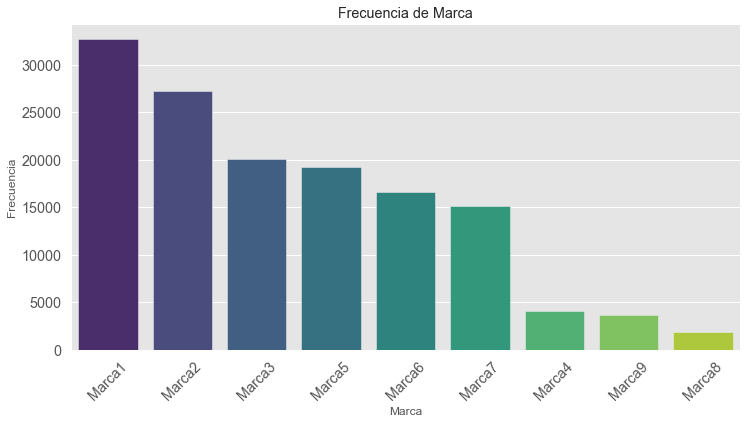

In [10]:
# Frecuencia de cada marca
plt.figure(figsize=(12, 6))
sns.countplot(x='brand', data=ventas_df, order=ventas_df['brand'].value_counts().index, palette='viridis')
plt.title('Frecuencia de Marca')
plt.xlabel('Marca')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


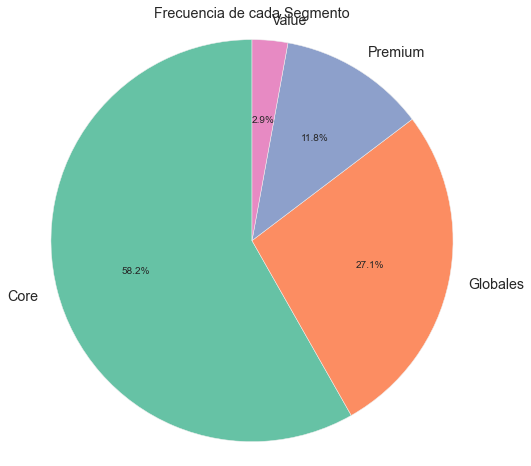

In [11]:
# Contar la frecuencia de cada segmento
segment_frecuencia = ventas_df['segment'].value_counts()

# Crear el diagrama de torta
plt.figure(figsize=(8,8))
plt.pie(segment_frecuencia, labels=segment_frecuencia.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))

# Título del gráfico
plt.title('Frecuencia de cada Segmento')

# Mostrar el gráfico
plt.axis('equal')  # Asegura que el gráfico sea circular
plt.show()

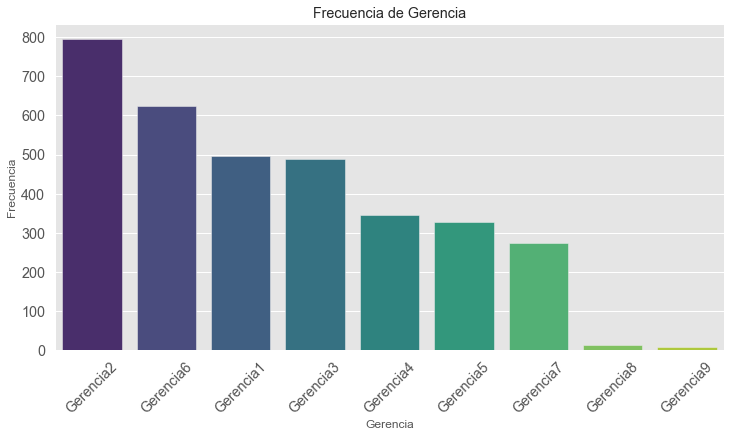

In [12]:
# Frecuencia de cada Gerencia
plt.figure(figsize=(12, 6))
sns.countplot(x='Gerencia', data=clientes_df, order=clientes_df['Gerencia'].value_counts().index, palette='viridis')
plt.title('Frecuencia de Gerencia')
plt.xlabel('Gerencia')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


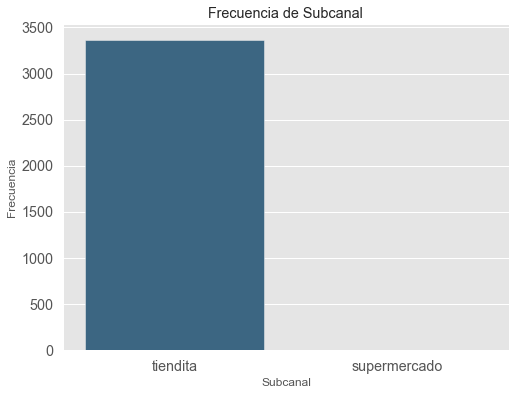

In [13]:
# Frecuencia de cada subcanal_
plt.figure(figsize=(8, 6))
sns.countplot(x='subcanal', data=clientes_df, palette='viridis')
plt.title('Frecuencia de Subcanal')
plt.xlabel('Subcanal')
plt.ylabel('Frecuencia')
plt.show()


In [14]:
# Conteo de categorías en 'subcanal'
subcanal_counts = clientes_df['subcanal'].value_counts()

print(subcanal_counts)


tiendita        3367
supermercado       2
Name: subcanal, dtype: int64


##### Variables Numéricas:

En ventas_df: ym, vol, nr, desc

En clientes_df: Sin variables numéricas

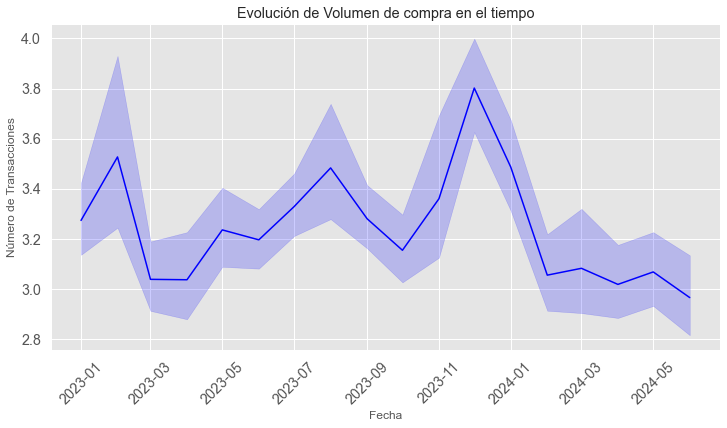

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Suponiendo que tienes un DataFrame llamado 'ventas_df' con una columna 'ym' en formato '202301'

# Convertir 'ym' a datetime
ventas_df['ym'] = pd.to_datetime(ventas_df['ym'], format='%Y%m')

# Crear el gráfico de línea
plt.figure(figsize=(12, 6))
sns.lineplot(x='ym', y='vol', data=ventas_df, color='blue')
plt.title('Evolución de Volumen de compra en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Transacciones')

# Formatear las etiquetas del eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

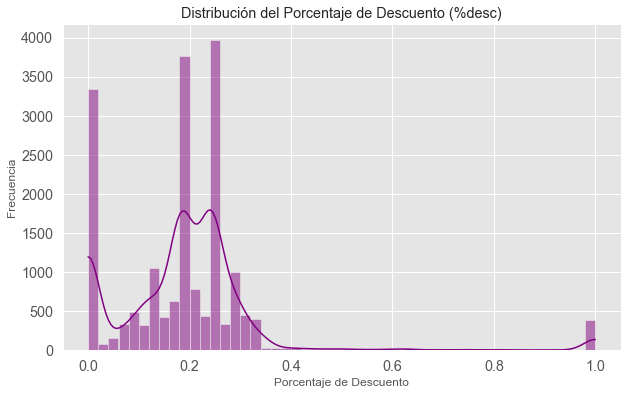

In [130]:
# Calcular %desc
ventas_marca3['%desc'] = abs(ventas_marca3['desc']) / (abs(ventas_marca3['desc']) + ventas_marca3['nr'])

# Graficar la distribución de %desc
plt.figure(figsize=(10, 6))
sns.histplot(ventas_marca3['%desc'], bins=50, kde=True, color='purple')
plt.title('Distribución del Porcentaje de Descuento (%desc)')
plt.xlabel('Porcentaje de Descuento')
plt.ylabel('Frecuencia')
plt.show()


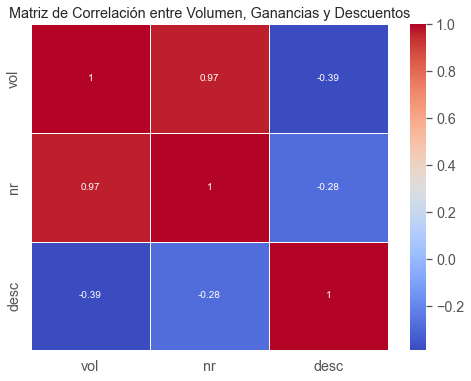

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las columnas numéricas
numerical_columns = ['vol', 'nr', 'desc']

# Calcular la matriz de correlación
correlacion = ventas_df[numerical_columns].corr()

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación entre Volumen, Ganancias y Descuentos')
plt.show()


           ym  total_vol      total_nr    total_desc
0  2023-01-01  23788.213  2.920549e+11 -1.067234e+10
1  2023-02-01  26897.589  3.292565e+11 -3.599398e+10
2  2023-03-01  24064.284  2.678111e+11 -2.334586e+10
3  2023-04-01  23176.773  2.566489e+11 -1.251463e+10
4  2023-05-01  24457.824  2.818572e+11 -1.404219e+10
5  2023-06-01  24234.219  2.779758e+11 -9.093465e+09
6  2023-07-01  25381.194  3.066962e+11 -1.023812e+10
7  2023-08-01  27356.715  3.517221e+11 -1.625670e+10
8  2023-09-01  26056.794  3.279055e+11 -1.806419e+10
9  2023-10-01  25078.886  3.036483e+11 -2.436409e+10
10 2023-11-01  28180.680  3.616639e+11 -2.592460e+10
11 2023-12-01  29710.978  4.085485e+11 -2.348244e+10
12 2024-01-01  25008.379  3.412387e+11 -1.820599e+10
13 2024-02-01  23240.798  2.875368e+11 -1.213473e+10
14 2024-03-01  24034.356  2.933749e+11 -1.204698e+10
15 2024-04-01  24990.580  3.061307e+11 -1.711036e+10
16 2024-05-01  26945.640  3.363015e+11 -7.784526e+09
17 2024-06-01  23083.500  2.795447e+11 -9.5520

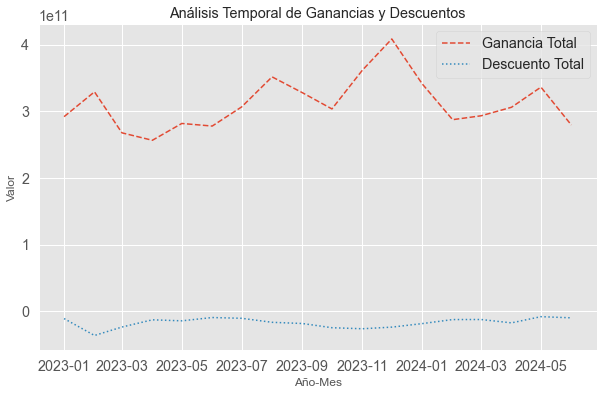

In [33]:
# Agrupación por mes
grouped_temporal = ventas_df.groupby('ym').agg(
    total_vol=('vol', 'sum'),
    total_nr=('nr', 'sum'),
    total_desc=('desc', 'sum')
).reset_index()

# Mostrar resultados
print(grouped_temporal)

# Si deseas visualizar
import matplotlib.pyplot as plt

# Graficar vol, nr y desc a lo largo del tiempo
plt.figure(figsize=(10,6))
plt.plot(grouped_temporal['ym'], grouped_temporal['total_nr'], label='Ganancia Total', linestyle='--')
plt.plot(grouped_temporal['ym'], grouped_temporal['total_desc'], label='Descuento Total', linestyle=':')
plt.xlabel('Año-Mes')
plt.ylabel('Valor')
plt.title('Análisis Temporal de Ganancias y Descuentos')
plt.legend()
plt.show()



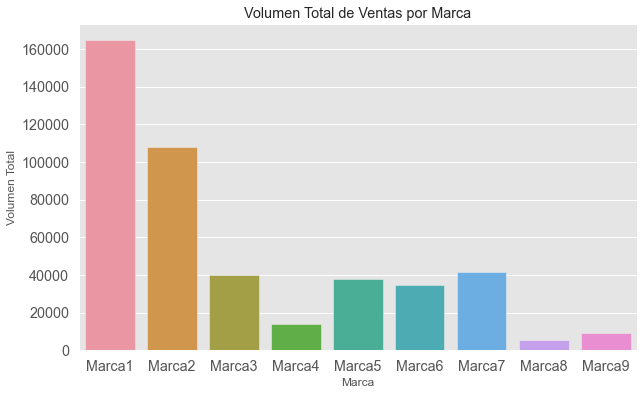

In [43]:
# Agrupar por marca
grouped_brand = ventas_df.groupby('brand').agg(
    total_vol=('vol', 'sum'),
    total_nr=('nr', 'sum'),
    total_desc=('desc', 'sum')
).reset_index()

# Graficar el volumen de ventas por marca
plt.figure(figsize=(10,6))
sns.barplot(x='brand', y='total_vol', data=grouped_brand)
plt.title('Volumen Total de Ventas por Marca')
plt.xlabel('Marca')
plt.ylabel('Volumen Total')
plt.show()


##### Análisis de clientes

In [48]:
# Contar la frecuencia de clientes por Gerencia y subcanal
perfil_clientes = clientes_df.groupby(['Gerencia', 'subcanal']).size().reset_index(name='Frecuencia')

# Mostrar los perfiles de clientes y su frecuencia
print(perfil_clientes)


    Gerencia      subcanal  Frecuencia
0  Gerencia1      tiendita         495
1  Gerencia2      tiendita         795
2  Gerencia3      tiendita         489
3  Gerencia4      tiendita         344
4  Gerencia5      tiendita         327
5  Gerencia6      tiendita         625
6  Gerencia7      tiendita         274
7  Gerencia8      tiendita          12
8  Gerencia9  supermercado           2
9  Gerencia9      tiendita           6


CLIENTES TOP


In [52]:
# Unir tablas de ventas y clientes
clientes_ventas = pd.merge(ventas_df, clientes_df, on='Cliente')

# Agrupar por cliente y calcular el total de volumen, descuentos y ganancias
resumen_clientes = clientes_ventas.groupby('Cliente').agg(
    total_vol=('vol', 'sum'),
    total_desc=('desc', 'sum'),
    total_nr=('nr', 'sum')
).reset_index()


In [53]:
from sklearn.preprocessing import StandardScaler

# Normalizar las variables
scaler = StandardScaler()
resumen_clientes_scaled = scaler.fit_transform(resumen_clientes[['total_vol', 'total_desc', 'total_nr']])


In [56]:
from sklearn.preprocessing import StandardScaler

# Normalizar las variables
scaler = StandardScaler()
resumen_clientes_scaled = scaler.fit_transform(resumen_clientes[['total_vol', 'total_desc', 'total_nr']])


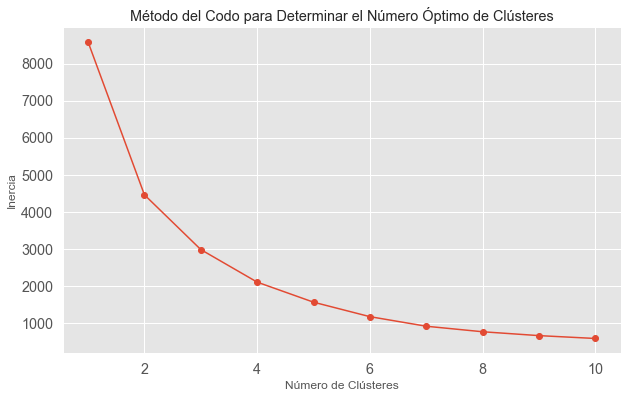

In [57]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calcular la suma de los errores cuadráticos (inertia) para diferentes números de clústeres
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(resumen_clientes_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo para Determinar el Número Óptimo de Clústeres')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()


In [58]:
# Aplicar K-means con el número óptimo de clústeres (supongamos que es 4)
kmeans = KMeans(n_clusters=4, random_state=0)
resumen_clientes['Cluster'] = kmeans.fit_predict(resumen_clientes_scaled)

# Mostrar los primeros datos de los clústeres
print(resumen_clientes.head())


   Cliente  total_vol    total_desc      total_nr  Cluster
0     cte1    102.156 -4.199025e+06  8.485717e+08        1
1    cte10    322.448 -1.229054e+08  4.171717e+09        1
2   cte100    305.326 -8.962847e+07  3.142191e+09        1
3  cte1000     69.481 -2.960051e+06  3.047117e+08        1
4  cte1001    103.364 -2.867637e+07  1.004562e+09        1


In [59]:
# Resumen de cada clúster
cluster_summary = resumen_clientes.groupby('Cluster').agg(
    mean_vol=('total_vol', 'mean'),
    mean_desc=('total_desc', 'mean'),
    mean_nr=('total_nr', 'mean'),
    num_clients=('Cliente', 'count')
).reset_index()

print(cluster_summary)


   Cluster     mean_vol     mean_desc       mean_nr  num_clients
0        0  1065.431150 -8.577571e+08  1.522130e+10          160
1        1   126.241507 -5.265266e+07  1.233351e+09         2675
2        2  8691.397667 -4.654299e+09  1.695375e+11            3
3        3  2807.304435 -4.167714e+09  4.562960e+10           23


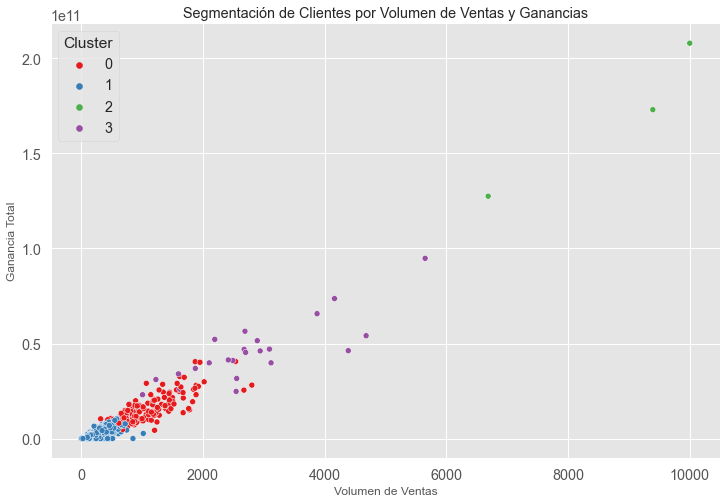

In [60]:
import seaborn as sns

# Graficar los clústeres
plt.figure(figsize=(12,8))
sns.scatterplot(x='total_vol', y='total_nr', hue='Cluster', data=resumen_clientes, palette='Set1')
plt.title('Segmentación de Clientes por Volumen de Ventas y Ganancias')
plt.xlabel('Volumen de Ventas')
plt.ylabel('Ganancia Total')
plt.legend(title='Cluster')
plt.show()


# Modelado

In [139]:
# Filtrar y unir datos
ventas_marca3 = ventas[ventas['brand'] == 'Marca3']
datos = ventas_marca3.merge(clientes_df, on='Cliente')

# Crear variable objetivo
umbral = datos['vol'].quantile(0.75)
datos['compra'] = (datos['vol'] > umbral).astype(int)  # Asume que una compra significa vol > 

# Seleccionar variables
X = datos[['vol','desc','segment', 'Gerencia']]
y = datos['compra']
# Codificar variables categóricas
X = pd.get_dummies(X, columns=['segment', 'Gerencia'])
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [140]:
# Crear el modelo
modelo = LogisticRegression(max_iter=1000, random_state=42)

# Ajustar el modelo
modelo.fit(X_train, y_train)
# Realizar predicciones
y_pred = modelo.predict(X_test)

# Obtener probabilidades de predicción
y_prob = modelo.predict_proba(X_test)[:, 1]

# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC: {roc_auc:.2f}")

Matriz de Confusión:
[[1737 4337]
 [ 133 1806]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.29      0.44      6074
           1       0.29      0.93      0.45      1939

    accuracy                           0.44      8013
   macro avg       0.61      0.61      0.44      8013
weighted avg       0.78      0.44      0.44      8013


AUC-ROC: 0.91


MEJORANDO EL MODELO CON UNDERSAMPLING

In [145]:
# Recolección de muestras balanceadas (undersampling)
# Separar las clases
datos_no_compra = datos[datos['compra'] == 0]
datos_compra = datos[datos['compra'] == 1]

# Hacer undersampling de la clase mayoritaria (no compra)
datos_no_compra_under = resample(datos_no_compra, 
                                 replace=False,  # No repetir muestras
                                 n_samples=len(datos_compra),  # Igual número que la clase minoritaria
                                 random_state=42)

# Concatenar las muestras balanceadas
datos_balanceados = pd.concat([datos_no_compra_under, datos_compra])


# Crear el conjunto de variables
X = datos_balanceados[['vol', 'desc', 'segment', 'Gerencia']]
y = datos_balanceados['compra']

# Codificar variables categóricas
X = pd.get_dummies(X, columns=['segment', 'Gerencia'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo con class_weight='balanced'
modelo = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Ajustar el modelo
modelo.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC: {roc_auc:.2f}")

Matriz de Confusión:
[[ 548 1473]
 [ 125 1859]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.27      0.41      2021
           1       0.56      0.94      0.70      1984

    accuracy                           0.60      4005
   macro avg       0.69      0.60      0.55      4005
weighted avg       0.69      0.60      0.55      4005


AUC-ROC: 0.91


MEJORANDO EL MODELO CON OVERSAMPLING

In [147]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear las clases mediante oversampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Dividir los datos balanceados
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Ajustar el modelo con class_weight='balanced'
modelo = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
modelo.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC: {roc_auc:.2f}")



Matriz de Confusión:
[[ 548 1473]
 [ 125 1859]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.27      0.41      2021
           1       0.56      0.94      0.70      1984

    accuracy                           0.60      4005
   macro avg       0.69      0.60      0.55      4005
weighted avg       0.69      0.60      0.55      4005


AUC-ROC: 0.91


Usando PCA

In [153]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X)

# Dividir los datos balanceados
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Crear el modelo
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Ajustar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC: {roc_auc:.2f}")


Matriz de Confusión:
[[2008   13]
 [1052  932]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      2021
           1       0.99      0.47      0.64      1984

    accuracy                           0.73      4005
   macro avg       0.82      0.73      0.71      4005
weighted avg       0.82      0.73      0.71      4005


AUC-ROC: 0.93


MEJORANDO EL PCA 

In [154]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Probar diferentes números de componentes principales
for n in [0.95, 0.90, 0.85, 0.80]:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
    
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\nPCA with {n} variance explained:")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC: {roc_auc:.2f}")



PCA with 0.95 variance explained:
Matriz de Confusión:
[[2008   13]
 [1052  932]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      2021
           1       0.99      0.47      0.64      1984

    accuracy                           0.73      4005
   macro avg       0.82      0.73      0.71      4005
weighted avg       0.82      0.73      0.71      4005

AUC-ROC: 0.93

PCA with 0.9 variance explained:
Matriz de Confusión:
[[2008   13]
 [1052  932]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      2021
           1       0.99      0.47      0.64      1984

    accuracy                           0.73      4005
   macro avg       0.82      0.73      0.71      4005
weighted avg       0.82      0.73      0.71      4005

AUC-ROC: 0.93

PCA with 0.85 variance explained:
Matriz de Confusión:
[[2008   13]
 [1052  932]]

Reporte de Clas

Comparación

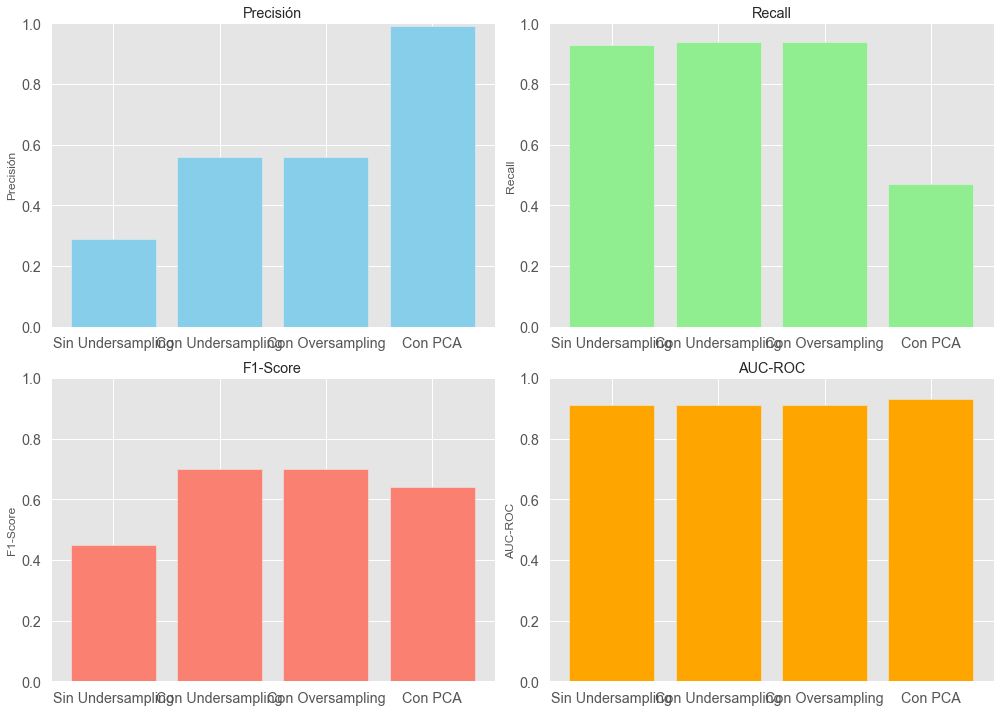

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los datos de rendimiento para cada enfoque
modelos = ['Sin Undersampling', 'Con Undersampling', 'Con Oversampling', 'Con PCA']
precisiones = [0.29, 0.56, 0.56, 0.99]  # Ejemplos de precisión
recalls = [0.93, 0.94, 0.94, 0.47]  # Ejemplos de recall
f1_scores = [0.45, 0.70, 0.70, 0.64]  # Ejemplos de F1-score
auc_roc = [0.91, 0.91, 0.91, 0.93]  # Ejemplos de AUC-ROC

# Crear la figura y los ejes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Graficar precisión
ax[0, 0].bar(modelos, precisiones, color='skyblue')
ax[0, 0].set_title('Precisión')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Precisión')

# Graficar recall
ax[0, 1].bar(modelos, recalls, color='lightgreen')
ax[0, 1].set_title('Recall')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('Recall')

# Graficar F1-score
ax[1, 0].bar(modelos, f1_scores, color='salmon')
ax[1, 0].set_title('F1-Score')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('F1-Score')

# Graficar AUC-ROC
ax[1, 1].bar(modelos, auc_roc, color='orange')
ax[1, 1].set_title('AUC-ROC')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('AUC-ROC')

# Ajustar el diseño
plt.tight_layout()
plt.show()
